In [28]:
#import squidpy as sq
import scanpy as sc
import anndata as ad
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt

import scipy
%config InlineBackend.figure_format = 'retina'

In [29]:
#from utils import *
from sklearn.neighbors import kneighbors_graph
from sklearn.neighbors import kneighbors_graph
from scipy.sparse import csgraph, csr_matrix
from sklearn.metrics import adjusted_rand_score as ari_score

In [30]:
import os,csv,re
import math
from scipy.sparse import issparse
import warnings
warnings.filterwarnings("ignore")
import matplotlib.colors as clr
import matplotlib.pyplot as plt
import argparse
from scanpy import read_10x_h5
from sklearn.metrics import pairwise_distances as pair
import scipy.sparse as sp
import h5py
from scipy.sparse import coo_matrix

In [31]:
from sklearn.cluster import KMeans
from sklearn.metrics import pairwise_distances as pair

In [32]:
import scanpy as sc
import anndata as ad
import squidpy as sq

import pandas as pd

import matplotlib.pyplot as plt

sc.logging.print_header()
print(f"squidpy=={sq.__version__}")


scanpy==1.9.6 anndata==0.9.1 umap==0.5.3 numpy==1.21.6 scipy==1.9.1 pandas==2.0.1 scikit-learn==0.24.0 statsmodels==0.14.0 igraph==0.10.4 louvain==0.8.0 pynndescent==0.5.10
squidpy==1.2.3


In [33]:
import scanpy as sc
from matplotlib.pyplot import rc_context
sc.set_figure_params( color_map = 'viridis_r',figsize=(5,5))

In [34]:
import time

In [35]:

def Run_GPCA(adata, location, n_components = 50, method = "knn", platform = "Visium", _lambda = 0.5, n_neighbors=6):
    Expr = adata.X
    if issparse(Expr):
        Expr = Expr.todense()
        
    if platform=="Visium":
        n_neighbors = 6
    elif platform=="ST":
        n_neighbors = 4
    if method=="knn":    
        graph = kneighbors_graph(np.asarray(location), int(n_neighbors), metric='euclidean',
                                             metric_params={}, include_self=False)
        graph = 0.5 * (graph + graph.T)
        graphL = csgraph.laplacian(graph,normed=False)
    
    G = scipy.sparse.eye(location.shape[0]) + _lambda * graphL
    if issparse(G):
        Ginv = np.array(np.linalg.inv(G.todense()))
    else:
        Ginv = np.array(np.linalg.inv(G))
    C = np.dot(np.dot(Expr.T,Ginv),Expr)
    lambdas,W = np.linalg.eigh(C)
    W = W[:, ::-1]
    W = W[:, :n_components]
    Z = np.dot(np.dot(Ginv,Expr),W)
    return Z

In [36]:
def refine(sample_id, pred, dis, shape="hexagon"):
    refined_pred=[]
    pred=pd.DataFrame({"pred": pred}, index=sample_id)
    dis_df=pd.DataFrame(dis, index=sample_id, columns=sample_id)
    if shape=="hexagon":
        num_nbs=6 
    elif shape=="square":
        num_nbs=4
    else:
        print("Shape not recongized, shape='hexagon' for Visium data, 'square' for ST data.")
    for i in range(len(sample_id)):
        index=sample_id[i]
        dis_tmp=dis_df.loc[index, :].sort_values()
        nbs=dis_tmp[0:num_nbs+1]
        nbs_pred=pred.loc[nbs.index, "pred"]
        self_pred=pred.loc[index, "pred"]
        v_c=nbs_pred.value_counts()
        if (v_c.loc[self_pred]<num_nbs/2) and (np.max(v_c)>num_nbs/2):
            refined_pred.append(v_c.idxmax())
        else:           
            refined_pred.append(self_pred)
    return refined_pred

In [37]:

samples = ["151507", "151508", "151509", "151510", "151669", "151670",
           "151671", "151672", "151673", "151674", "151675", "151676"]
BestK=[7,7,7,7,5,5,5,5,7,7,7,7]
data_path = "../../data/DLPFC/"
save_path = "../../results/DLPFC/"
path_GT = "../../data/DLPFC/groundtruth/SpatialDE_clustering/cluster_labels_"
sample_id = 8
PCA_components = 50

In [38]:
#slice_inds = np.arange(0,4)
#slice_inds = np.arange(4,8)
slice_inds = np.arange(8,12)

In [12]:
slice_inds

array([4, 5, 6, 7])

## We noticed that the sample id (151674) has a poor clustering performance

In [318]:
adata = sc.read("../../results/DLPFC/151674_GPCA.h5ad")

In [319]:
adata

AnnData object with n_obs × n_vars = 3673 × 3000
    obs: 'in_tissue', 'array_row', 'array_col', 'groundtruth', 'GPCA_pred'
    var: 'gene_ids', 'feature_types', 'genome', 'n_cells', 'mean', 'std'
    uns: 'pearson_residuals_normalization', 'spatial'
    obsm: 'spatial'

In [327]:
ari_score(adata.obs.GPCA_pred,adata.obs.groundtruth)

0.38118361037362425

In [320]:
adata.uns['groundtruth_colors'] = ["#9E0142","#D53E4F","#F46D43","#FDAE61","#FEE08B","#FFFFBF","#E6F598","#ABDDA4"]
adata.uns['GPCA_pred_colors'] = np.array(["#9E0142","#D53E4F","#F46D43","#FDAE61","#FEE08B","#FFFFBF","#ABDDA4"])

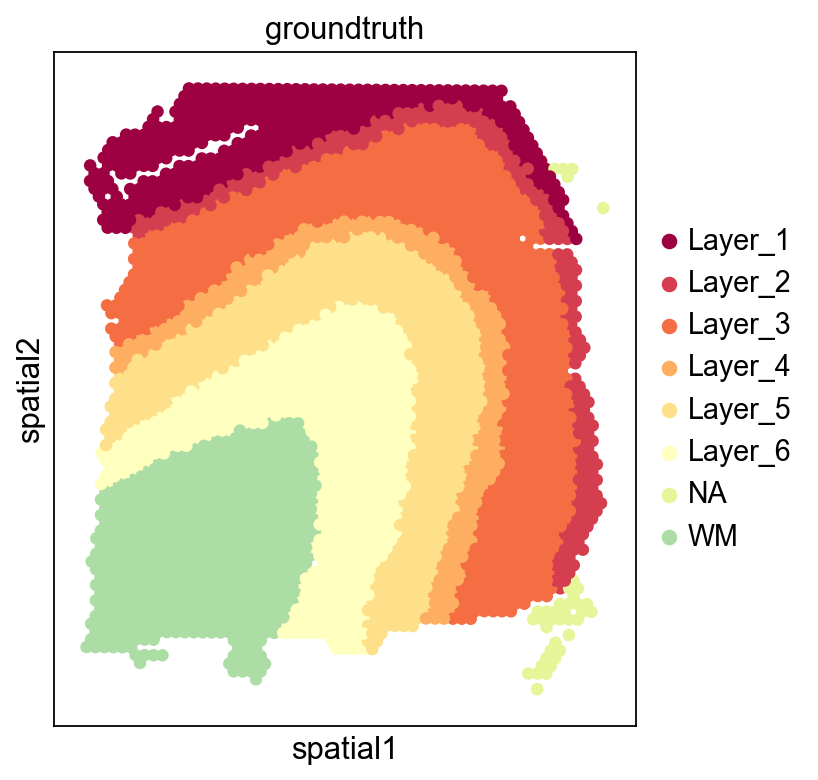

In [311]:
sq.pl.spatial_scatter(adata, color=["groundtruth"],img=False,size=2)

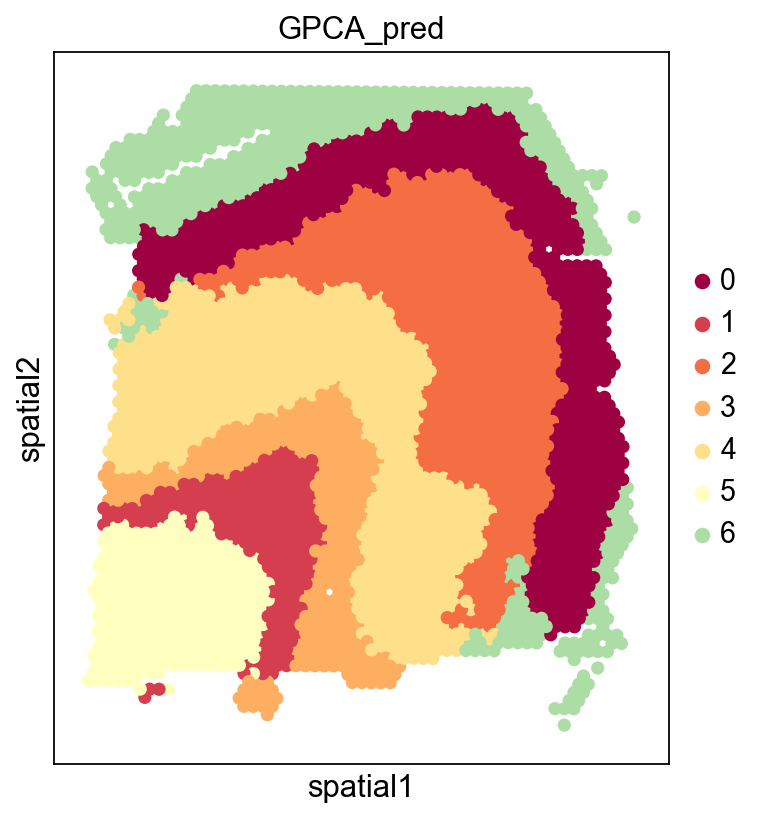

In [321]:
sq.pl.spatial_scatter(adata, color=["GPCA_pred"],img=False,size=2)

In [322]:
match_list = dict(zip(range(BestK[sample_id]),[1,5,2,4,3,6,0]))
adata.obs["GPCA_pred"] = [match_list[x] for x in adata.obs["GPCA_pred"]]
adata.obs["GPCA_pred"] = adata.obs["GPCA_pred"].astype('category')

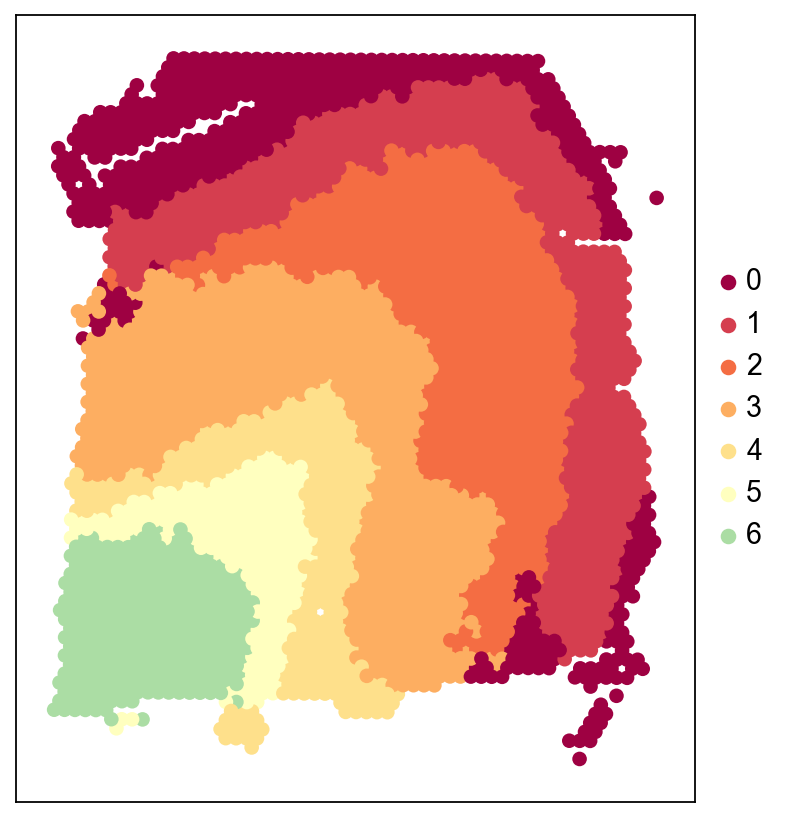

In [326]:
sq.pl.spatial_scatter(adata, color=["GPCA_pred"],img=False,size=2,title="",
                      axis_label=["",""],save="151674_GPCA.pdf")

In [324]:
adata.write_h5ad("../../results/DLPFC/151674_GPCA.h5ad")

## We integrated four slices to advance the performance 

In [13]:
Batch_list = []
adj_list = []


for sample_id in slice_inds:
    print(samples[sample_id])
   
    adata = sc.read(data_path + samples[sample_id] + "/sample_data.h5ad")
    groundtruth=pd.read_csv(path_GT+samples[sample_id]+".csv", sep=",",header=0,na_filter=False,index_col=0) 
    groundtruth=np.array(groundtruth["ground_truth"])
    adata.obs["groundtruth"] = groundtruth
    

    # make spot name unique
    adata.obs_names = [x+'_'+ samples[sample_id] for x in adata.obs_names]

    
    ## Constructing the spatial network
    x_array=adata.obs["array_row"].tolist()
    y_array=adata.obs["array_col"].tolist()
    X=np.array([x_array, y_array]).T.astype(np.float32)
    n_neighbors = 6
    graph = kneighbors_graph(np.asarray(X), int(n_neighbors), metric='euclidean',
                                     metric_params={}, include_self=False)
    graph = 0.5 * (graph + graph.T)

    adata.uns["adj"] = graph
  

    # Normalization
    sc.pp.filter_genes(adata,min_cells=20)
    sc.experimental.pp.normalize_pearson_residuals(adata)
    sc.pp.scale(adata)
    SVG_list = pd.read_csv("../../results/DLPFC/SpatialPCA_data_preprocess/" + samples[sample_id] + "_SVGs.csv",index_col=0)
    adata = adata[:,adata.var.gene_ids.isin(SVG_list.x)] 

    adj_list.append(adata.uns['adj'])
    Batch_list.append(adata)

151669
151670
151671
151672


In [14]:
Batch_list

[View of AnnData object with n_obs × n_vars = 3661 × 1502
     obs: 'in_tissue', 'array_row', 'array_col', 'groundtruth'
     var: 'gene_ids', 'feature_types', 'genome', 'n_cells', 'mean', 'std'
     uns: 'spatial', 'adj', 'pearson_residuals_normalization'
     obsm: 'spatial',
 View of AnnData object with n_obs × n_vars = 3498 × 1525
     obs: 'in_tissue', 'array_row', 'array_col', 'groundtruth'
     var: 'gene_ids', 'feature_types', 'genome', 'n_cells', 'mean', 'std'
     uns: 'spatial', 'adj', 'pearson_residuals_normalization'
     obsm: 'spatial',
 View of AnnData object with n_obs × n_vars = 4110 × 3000
     obs: 'in_tissue', 'array_row', 'array_col', 'groundtruth'
     var: 'gene_ids', 'feature_types', 'genome', 'n_cells', 'mean', 'std'
     uns: 'spatial', 'adj', 'pearson_residuals_normalization'
     obsm: 'spatial',
 View of AnnData object with n_obs × n_vars = 4015 × 2785
     obs: 'in_tissue', 'array_row', 'array_col', 'groundtruth'
     var: 'gene_ids', 'feature_types', 'ge

In [15]:
adata_concat = ad.concat(Batch_list, label="slice_name", keys=samples[slice_inds[0]:slice_inds[-1]+1])
adata_concat.obs['groundtruth'] = adata_concat.obs['groundtruth'].astype('category')
adata_concat.obs["batch_name"] = adata_concat.obs["slice_name"].astype('category')
print('adata_concat.shape: ', adata_concat.shape)

adata_concat.shape:  (15284, 1016)


In [16]:
adj_list

[<3661x3661 sparse matrix of type '<class 'numpy.float64'>'
 	with 25524 stored elements in Compressed Sparse Row format>,
 <3498x3498 sparse matrix of type '<class 'numpy.float64'>'
 	with 24338 stored elements in Compressed Sparse Row format>,
 <4110x4110 sparse matrix of type '<class 'numpy.float64'>'
 	with 28346 stored elements in Compressed Sparse Row format>,
 <4015x4015 sparse matrix of type '<class 'numpy.float64'>'
 	with 27820 stored elements in Compressed Sparse Row format>]

In [17]:
adj_concat = np.asarray(adj_list[0].todense())
for batch_id in range(1,len(samples[slice_inds[0]:slice_inds[-1]+1])):
    adj_concat = scipy.linalg.block_diag(adj_concat, np.asarray(adj_list[batch_id].todense()))
adata_concat.uns['edgeList'] = np.nonzero(adj_concat)
adata_concat.uns['network'] = scipy.sparse.csr_matrix(adj_concat)

In [18]:
adata_concat

AnnData object with n_obs × n_vars = 15284 × 1016
    obs: 'in_tissue', 'array_row', 'array_col', 'groundtruth', 'slice_name', 'batch_name'
    uns: 'edgeList', 'network'
    obsm: 'spatial'

In [19]:
adata_concat.uns["edgeList"]

(array([    0,     0,     0, ..., 15283, 15283, 15283], dtype=int64),
 array([  397,   493,  1072, ..., 14039, 15028, 15200], dtype=int64))

In [20]:
adata_concat.uns['network']

<15284x15284 sparse matrix of type '<class 'numpy.float64'>'
	with 106028 stored elements in Compressed Sparse Row format>

In [21]:
def Run_GPCA(adata, location = None, network = None, n_components = 50, method = "knn", platform = "Visium", _lambda = 0.5, n_neighbors=6):
    Expr = adata.X
    if issparse(Expr):
        Expr = Expr.todense()
        
    if network is not None:
        graph = network
    else:
        if platform=="Visium":
            n_neighbors = 6
        elif platform=="ST":
            n_neighbors = 4
        if method=="knn":    
            graph = kneighbors_graph(np.asarray(location), int(n_neighbors), metric='euclidean',
                                                 metric_params={}, include_self=False)
            graph = 0.5 * (graph + graph.T)
    graphL = csgraph.laplacian(graph,normed=False)
    
    G = scipy.sparse.eye(adata.shape[0]) + _lambda * graphL
    if issparse(G):
        Ginv = np.array(np.linalg.inv(G.todense()))
    else:
        Ginv = np.array(np.linalg.inv(G))
    C = np.dot(np.dot(Expr.T,Ginv),Expr)
    lambdas,W = np.linalg.eigh(C)
    W = W[:, ::-1]
    W = W[:, :n_components]
    Z = np.dot(np.dot(Ginv,Expr),W)
    return Z

In [22]:
Z = Run_GPCA(adata_concat, network=adata_concat.uns['network'], n_components = 50, method = "knn", platform = "Visium", _lambda = 0.5)


In [44]:
adata_concat = sc.read("../../results/DLPFC/151673-76_GPCA.h5ad")
Z = adata_concat.obsm["GraphPCA"] 

In [56]:
for i in range(200,300):
    estimator = KMeans(n_clusters=7,random_state=i)
    res = estimator.fit(Z[:,:])
    lable_pred=res.labels_
    adata_concat.obs["GPCA_pred"]= lable_pred
    adata_concat.obs["GPCA_pred"] = adata_concat.obs["GPCA_pred"].astype('category')
    adata_concat = adata_concat[adata_concat.obs['groundtruth']!='NA']
    print(ari_score(adata_concat.obs.GPCA_pred,adata_concat.obs.groundtruth))

0.5114662109397786
0.5107981101528356
0.5117747915479406
0.5109739766202764
0.5114225793366053
0.5101831670990732
0.5099568094807322
0.5114662109397786
0.5118015779603189
0.5101757361124611
0.5129135535381019
0.511382125192721
0.5099385616330727
0.5117747915479406
0.5109739766202764
0.5114662109397786
0.5109739766202764
0.5100187265221677
0.51052891591128
0.5109739766202764
0.5109739766202764
0.5097108725503563
0.5117747915479406
0.5117747915479406
0.5117747915479406
0.5104503485900344
0.5114247769426331
0.5117747915479406
0.5112909103592332
0.5113887157015549
0.5109739766202764
0.5110779057769627
0.5114662109397786
0.5117747915479406
0.5117747915479406
0.5108685396709625
0.5101218652657817
0.5117747915479406
0.5108115484266911
0.5097517391594442
0.5117747915479406
0.5109739766202764
0.5114662109397786
0.5099568094807322
0.5100292782840596
0.5099412209497721
0.5117747915479406
0.5096748705080872
0.5107473011403063
0.511011945280682
0.5101124446819364
0.5117747915479406
0.51050269001923

In [23]:
estimator = KMeans(n_clusters=BestK[slice_inds[0]],random_state=501)
res = estimator.fit(Z[:,:])
lable_pred=res.labels_
adata_concat.obs["GPCA_pred"]= lable_pred
adata_concat.obs["GPCA_pred"] = adata_concat.obs["GPCA_pred"].astype('category')
adata_concat.obsm["GraphPCA"] = Z

In [24]:
adata_concat = adata_concat[adata_concat.obs['groundtruth']!='NA']

In [25]:
print(ari_score(adata_concat.obs.GPCA_pred,adata_concat.obs.groundtruth))

0.48805755039409093


In [26]:
del adata_concat.uns

In [27]:
adata_concat.write_h5ad("../../results/DLPFC/151669-72_GPCA.h5ad")

In [346]:
sc.pp.neighbors(adata_concat, use_rep='GraphPCA', random_state=666)
sc.tl.umap(adata_concat, random_state=666)

section_color = ['#f8766d', '#7cae00', '#00bfc4', '#c77cff']
section_color_dict = dict(zip(samples[slice_inds[0]:slice_inds[-1]+1], section_color))
adata_concat.uns['batch_name_colors'] = [section_color_dict[x] for x in adata_concat.obs.batch_name.cat.categories]


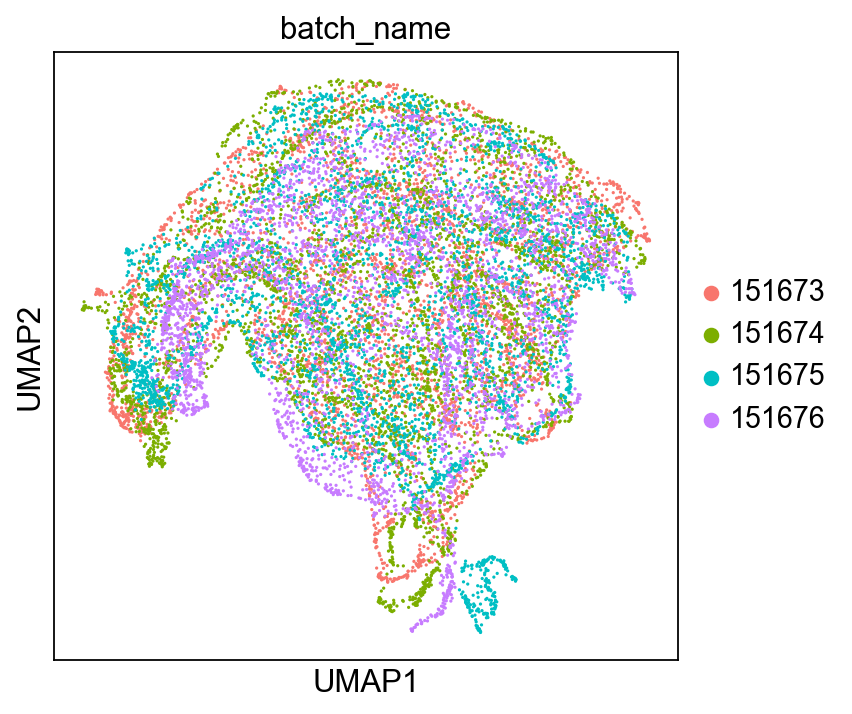

In [347]:
sc.pl.umap(adata_concat, color=['batch_name'], wspace=0.5, show=True)

In [348]:
import pandas as pd
import numpy as np
import sklearn.neighbors
import networkx as nx

In [349]:
def match_cluster_labels(true_labels,est_labels):
    true_labels_arr = np.array(list(true_labels))
    est_labels_arr = np.array(list(est_labels))
    org_cat = list(np.sort(list(pd.unique(true_labels))))
    est_cat = list(np.sort(list(pd.unique(est_labels))))
    B = nx.Graph()
    B.add_nodes_from([i+1 for i in range(len(org_cat))], bipartite=0)
    B.add_nodes_from([-j-1 for j in range(len(est_cat))], bipartite=1)
    for i in range(len(org_cat)):
        for j in range(len(est_cat)):
            weight = np.sum((true_labels_arr==org_cat[i])* (est_labels_arr==est_cat[j]))
            B.add_edge(i+1,-j-1, weight=-weight)
    match = nx.algorithms.bipartite.matching.minimum_weight_full_matching(B)
#     match = minimum_weight_full_matching(B)
    if len(org_cat)>=len(est_cat):
        return np.array([match[-est_cat.index(c)-1]-1 for c in est_labels_arr])
    else:
        unmatched = [c for c in est_cat if not (-est_cat.index(c)-1) in match.keys()]
        l = []
        for c in est_labels_arr:
            if (-est_cat.index(c)-1) in match: 
                l.append(match[-est_cat.index(c)-1]-1)
            else:
                l.append(len(org_cat)+unmatched.index(c))
        return np.array(l)

In [350]:
adata_concat.obs['GPCA_pred'] = pd.Series(match_cluster_labels(adata_concat.obs['groundtruth'], adata_concat.obs['GPCA_pred'].values),
                                         index=adata_concat.obs.index, dtype='category')

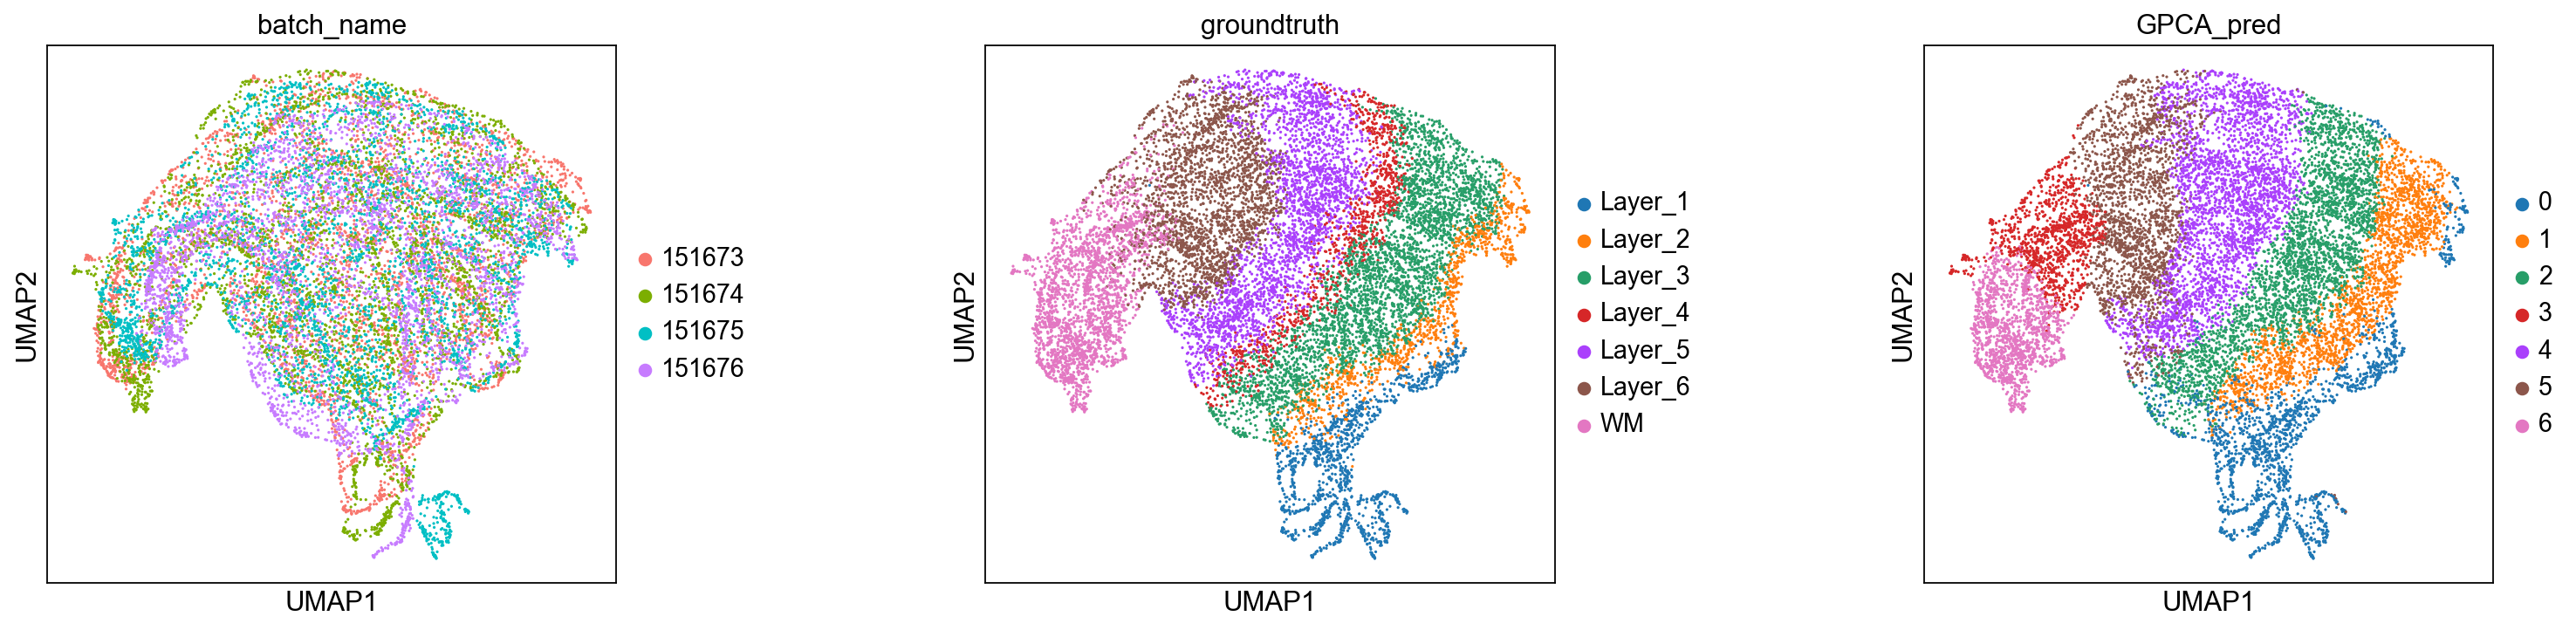

In [351]:
sc.pl.umap(adata_concat, color=['batch_name', 'groundtruth', 'GPCA_pred'], ncols=3, wspace=0.5, show=True)

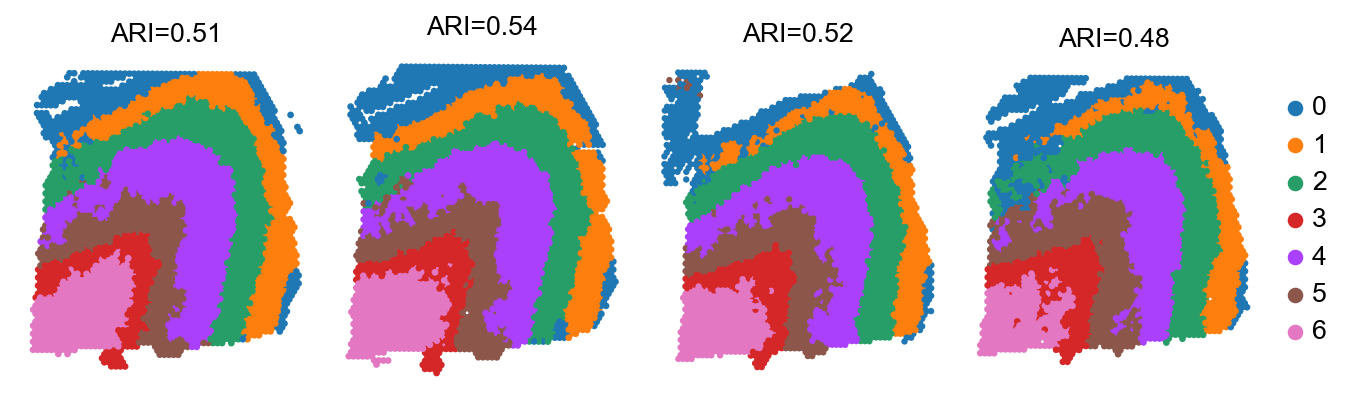

In [352]:
Batch_list = []
for section_id in samples[slice_inds[0]:slice_inds[-1]+1]:
    Batch_list.append(adata_concat[adata_concat.obs['batch_name'] == section_id])

import matplotlib.pyplot as plt
spot_size = 200
title_size = 12
ARI_list = []
for bb in range(4):
    ARI_list.append(round(ari_score(Batch_list[bb].obs['groundtruth'], Batch_list[bb].obs['GPCA_pred']), 2))

fig, ax = plt.subplots(1, 4, figsize=(10, 5), gridspec_kw={'wspace': 0.05, 'hspace': 0.1})
_sc_0 = sc.pl.spatial(Batch_list[0], img_key=None, color=['GPCA_pred'], title=[''],
                      legend_loc=None, legend_fontsize=12, show=False, ax=ax[0], frameon=False,
                      spot_size=spot_size)
_sc_0[0].set_title("ARI=" + str(ARI_list[0]), size=title_size)
_sc_1 = sc.pl.spatial(Batch_list[1], img_key=None, color=['GPCA_pred'], title=[''],
                      legend_loc=None, legend_fontsize=12, show=False, ax=ax[1], frameon=False,
                      spot_size=spot_size)
_sc_1[0].set_title("ARI=" + str(ARI_list[1]), size=title_size)
_sc_2 = sc.pl.spatial(Batch_list[2], img_key=None, color=['GPCA_pred'], title=[''],
                      legend_loc=None, legend_fontsize=12, show=False, ax=ax[2], frameon=False,
                      spot_size=spot_size)
_sc_2[0].set_title("ARI=" + str(ARI_list[2]), size=title_size)
_sc_3 = sc.pl.spatial(Batch_list[3], img_key=None, color=['GPCA_pred'], title=[''],
                      legend_fontsize=12, show=False, ax=ax[3], frameon=False,
                      spot_size=spot_size)
_sc_3[0].set_title("ARI=" + str(ARI_list[3]), size=title_size)
plt.show()

In [353]:
for bb in range(4):
    
    refined_pred=refine(sample_id=Batch_list[bb].obs.index.tolist(), pred=Batch_list[bb].obs["GPCA_pred"].tolist(),
                        dis= pair(Batch_list[bb].obsm["spatial"]), shape="hexagon")
    Batch_list[bb].obs["GPCA_pred"] = refined_pred
    Batch_list[bb].obs["GPCA_pred"] = Batch_list[bb].obs["GPCA_pred"].astype('category')


In [ ]:
match_list = dict(zip(range(BestK[sample_id]),[1,5,2,4,3,6,0]))
adata.obs["GPCA_pred"] = [match_list[x] for x in adata.obs["GPCA_pred"]]
adata.obs["GPCA_pred"] = adata.obs["GPCA_pred"].astype('category')

Text(0.5, 1.0, 'ARI=0.48')

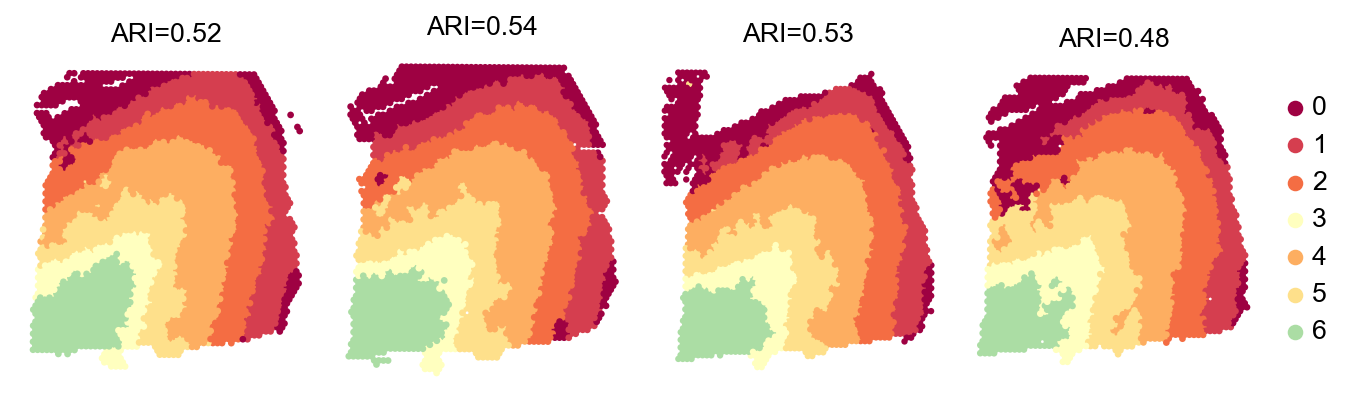

In [373]:
Ref_colors =  np.array(["#9E0142","#D53E4F","#F46D43","#FFFFBF","#FDAE61","#FEE08B","#ABDDA4"])

ARI_list = []
for bb in range(4):
    ARI_list.append(round(ari_score(Batch_list[bb].obs['groundtruth'], Batch_list[bb].obs['GPCA_pred']), 2))
    Batch_list[bb].uns['GPCA_pred_colors'] = Ref_colors
fig, ax = plt.subplots(1, 4, figsize=(10, 5), gridspec_kw={'wspace': 0.05, 'hspace': 0.1})

_sc_0 = sc.pl.spatial(Batch_list[0], img_key=None, color=['GPCA_pred'], title=[''],
                      legend_loc=None, legend_fontsize=12, show=False, ax=ax[0], frameon=False,
                      spot_size=spot_size)
_sc_0[0].set_title("ARI=" + str(ARI_list[0]), size=title_size)
_sc_1 = sc.pl.spatial(Batch_list[1], img_key=None, color=['GPCA_pred'], title=[''],
                      legend_loc=None, legend_fontsize=12, show=False, ax=ax[1], frameon=False,
                      spot_size=spot_size)
_sc_1[0].set_title("ARI=" + str(ARI_list[1]), size=title_size)
_sc_2 = sc.pl.spatial(Batch_list[2], img_key=None, color=['GPCA_pred'], title=[''],
                      legend_loc=None, legend_fontsize=12, show=False, ax=ax[2], frameon=False,
                      spot_size=spot_size)
_sc_2[0].set_title("ARI=" + str(ARI_list[2]), size=title_size)
_sc_3 = sc.pl.spatial(Batch_list[3], img_key=None, color=['GPCA_pred'], title=[''],
                      legend_fontsize=12, show=False, ax=ax[3], frameon=False,
                      spot_size=spot_size)
_sc_3[0].set_title("ARI=" + str(ARI_list[3]), size=title_size)
plt.show()

In [375]:
fig.savefig("../../results/DLPFC/figures/Multi-151673-76_GPCA.pdf")

## We demonstrate the integration performance of the remaining samples

In [376]:
slice_inds = np.arange(0,4)

In [377]:
Batch_list = []
adj_list = []


for sample_id in slice_inds:
    print(samples[sample_id])
   
    adata = sc.read(data_path + samples[sample_id] + "/sample_data.h5ad")
    groundtruth=pd.read_csv(path_GT+samples[sample_id]+".csv", sep=",",header=0,na_filter=False,index_col=0) 
    groundtruth=np.array(groundtruth["ground_truth"])
    adata.obs["groundtruth"] = groundtruth
    

    # make spot name unique
    adata.obs_names = [x+'_'+ samples[sample_id] for x in adata.obs_names]

    
    ## Constructing the spatial network
    x_array=adata.obs["array_row"].tolist()
    y_array=adata.obs["array_col"].tolist()
    X=np.array([x_array, y_array]).T.astype(np.float32)
    n_neighbors = 6
    graph = kneighbors_graph(np.asarray(X), int(n_neighbors), metric='euclidean',
                                     metric_params={}, include_self=False)
    graph = 0.5 * (graph + graph.T)

    adata.uns["adj"] = graph
  

    # Normalization
    sc.pp.filter_genes(adata,min_cells=20)
    sc.experimental.pp.normalize_pearson_residuals(adata)
    sc.pp.scale(adata)
    SVG_list = pd.read_csv("../../results/DLPFC/SpatialPCA_data_preprocess/" + samples[sample_id] + "_SVGs.csv",index_col=0)
    adata = adata[:,adata.var.gene_ids.isin(SVG_list.x)] 

    adj_list.append(adata.uns['adj'])
    Batch_list.append(adata)

151507
151508
151509
151510


In [378]:
Batch_list

[View of AnnData object with n_obs × n_vars = 4226 × 1288
     obs: 'in_tissue', 'array_row', 'array_col', 'groundtruth'
     var: 'gene_ids', 'feature_types', 'genome', 'n_cells', 'mean', 'std'
     uns: 'spatial', 'adj', 'pearson_residuals_normalization'
     obsm: 'spatial',
 View of AnnData object with n_obs × n_vars = 4384 × 1280
     obs: 'in_tissue', 'array_row', 'array_col', 'groundtruth'
     var: 'gene_ids', 'feature_types', 'genome', 'n_cells', 'mean', 'std'
     uns: 'spatial', 'adj', 'pearson_residuals_normalization'
     obsm: 'spatial',
 View of AnnData object with n_obs × n_vars = 4789 × 1494
     obs: 'in_tissue', 'array_row', 'array_col', 'groundtruth'
     var: 'gene_ids', 'feature_types', 'genome', 'n_cells', 'mean', 'std'
     uns: 'spatial', 'adj', 'pearson_residuals_normalization'
     obsm: 'spatial',
 View of AnnData object with n_obs × n_vars = 4634 × 1110
     obs: 'in_tissue', 'array_row', 'array_col', 'groundtruth'
     var: 'gene_ids', 'feature_types', 'ge

In [379]:
adata_concat = ad.concat(Batch_list, label="slice_name", keys=samples[slice_inds[0]:slice_inds[-1]+1])
adata_concat.obs['groundtruth'] = adata_concat.obs['groundtruth'].astype('category')
adata_concat.obs["batch_name"] = adata_concat.obs["slice_name"].astype('category')
print('adata_concat.shape: ', adata_concat.shape)

adata_concat.shape:  (18033, 716)


In [380]:
adj_list

[<4226x4226 sparse matrix of type '<class 'numpy.float64'>'
 	with 29102 stored elements in Compressed Sparse Row format>,
 <4384x4384 sparse matrix of type '<class 'numpy.float64'>'
 	with 30348 stored elements in Compressed Sparse Row format>,
 <4789x4789 sparse matrix of type '<class 'numpy.float64'>'
 	with 33216 stored elements in Compressed Sparse Row format>,
 <4634x4634 sparse matrix of type '<class 'numpy.float64'>'
 	with 32064 stored elements in Compressed Sparse Row format>]

In [381]:
adj_concat = np.asarray(adj_list[0].todense())
for batch_id in range(1,len(samples[slice_inds[0]:slice_inds[-1]+1])):
    adj_concat = scipy.linalg.block_diag(adj_concat, np.asarray(adj_list[batch_id].todense()))
adata_concat.uns['edgeList'] = np.nonzero(adj_concat)
adata_concat.uns['network'] = scipy.sparse.csr_matrix(adj_concat)

In [382]:
adata_concat

AnnData object with n_obs × n_vars = 18033 × 716
    obs: 'in_tissue', 'array_row', 'array_col', 'groundtruth', 'slice_name', 'batch_name'
    uns: 'edgeList', 'network'
    obsm: 'spatial'

In [383]:
adata_concat.uns["edgeList"]

(array([    0,     0,     0, ..., 18032, 18032, 18032], dtype=int64),
 array([ 1085,  1338,  2808, ..., 16349, 16581, 17746], dtype=int64))

In [384]:
adata_concat.uns['network']

<18033x18033 sparse matrix of type '<class 'numpy.float64'>'
	with 124730 stored elements in Compressed Sparse Row format>

In [385]:
def Run_GPCA(adata, location = None, network = None, n_components = 50, method = "knn", platform = "Visium", _lambda = 0.5, n_neighbors=6):
    Expr = adata.X
    if issparse(Expr):
        Expr = Expr.todense()
        
    if network is not None:
        graph = network
    else:
        if platform=="Visium":
            n_neighbors = 6
        elif platform=="ST":
            n_neighbors = 4
        if method=="knn":    
            graph = kneighbors_graph(np.asarray(location), int(n_neighbors), metric='euclidean',
                                                 metric_params={}, include_self=False)
            graph = 0.5 * (graph + graph.T)
    graphL = csgraph.laplacian(graph,normed=False)
    
    G = scipy.sparse.eye(adata.shape[0]) + _lambda * graphL
    if issparse(G):
        Ginv = np.array(np.linalg.inv(G.todense()))
    else:
        Ginv = np.array(np.linalg.inv(G))
    C = np.dot(np.dot(Expr.T,Ginv),Expr)
    lambdas,W = np.linalg.eigh(C)
    W = W[:, ::-1]
    W = W[:, :n_components]
    Z = np.dot(np.dot(Ginv,Expr),W)
    return Z

In [386]:
Z = Run_GPCA(adata_concat, network=adata_concat.uns['network'], n_components = 50, method = "knn", platform = "Visium", _lambda = 0.5)


In [387]:
estimator = KMeans(n_clusters=BestK[slice_inds[0]],random_state=501)
res = estimator.fit(Z[:,:])
lable_pred=res.labels_
adata_concat.obs["GPCA_pred"]= lable_pred
adata_concat.obs["GPCA_pred"] = adata_concat.obs["GPCA_pred"].astype('category')
adata_concat.obsm["GraphPCA"] = Z

In [388]:
adata_concat = adata_concat[adata_concat.obs['groundtruth']!='NA']

In [389]:
print(ari_score(adata_concat.obs.GPCA_pred,adata_concat.obs.groundtruth))

0.5164175276457094


In [390]:
adata_concat

View of AnnData object with n_obs × n_vars = 17985 × 716
    obs: 'in_tissue', 'array_row', 'array_col', 'groundtruth', 'slice_name', 'batch_name', 'GPCA_pred'
    uns: 'edgeList', 'network'
    obsm: 'spatial', 'GraphPCA'

In [391]:
sc.pp.neighbors(adata_concat, use_rep='GraphPCA', random_state=666)
sc.tl.umap(adata_concat, random_state=666)

section_color = ['#f8766d', '#7cae00', '#00bfc4', '#c77cff']
section_color_dict = dict(zip(samples[slice_inds[0]:slice_inds[-1]+1], section_color))
adata_concat.uns['batch_name_colors'] = [section_color_dict[x] for x in adata_concat.obs.batch_name.cat.categories]


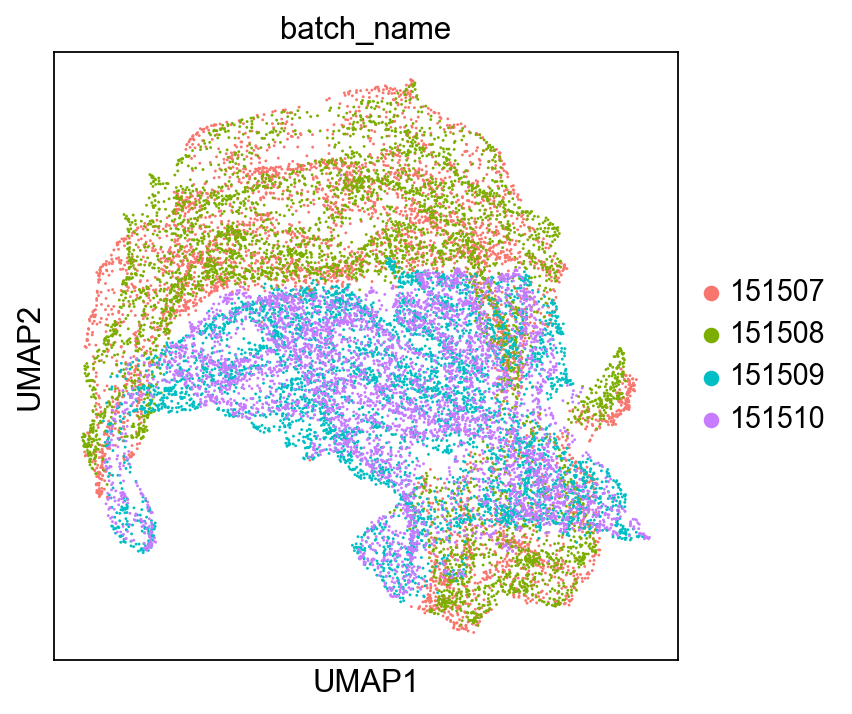

In [392]:
sc.pl.umap(adata_concat, color=['batch_name'], wspace=0.5, show=True)

In [393]:
import pandas as pd
import numpy as np
import sklearn.neighbors
import networkx as nx

In [394]:
def match_cluster_labels(true_labels,est_labels):
    true_labels_arr = np.array(list(true_labels))
    est_labels_arr = np.array(list(est_labels))
    org_cat = list(np.sort(list(pd.unique(true_labels))))
    est_cat = list(np.sort(list(pd.unique(est_labels))))
    B = nx.Graph()
    B.add_nodes_from([i+1 for i in range(len(org_cat))], bipartite=0)
    B.add_nodes_from([-j-1 for j in range(len(est_cat))], bipartite=1)
    for i in range(len(org_cat)):
        for j in range(len(est_cat)):
            weight = np.sum((true_labels_arr==org_cat[i])* (est_labels_arr==est_cat[j]))
            B.add_edge(i+1,-j-1, weight=-weight)
    match = nx.algorithms.bipartite.matching.minimum_weight_full_matching(B)
#     match = minimum_weight_full_matching(B)
    if len(org_cat)>=len(est_cat):
        return np.array([match[-est_cat.index(c)-1]-1 for c in est_labels_arr])
    else:
        unmatched = [c for c in est_cat if not (-est_cat.index(c)-1) in match.keys()]
        l = []
        for c in est_labels_arr:
            if (-est_cat.index(c)-1) in match: 
                l.append(match[-est_cat.index(c)-1]-1)
            else:
                l.append(len(org_cat)+unmatched.index(c))
        return np.array(l)

In [395]:
adata_concat.obs['GPCA_pred'] = pd.Series(match_cluster_labels(adata_concat.obs['groundtruth'], adata_concat.obs['GPCA_pred'].values),
                                         index=adata_concat.obs.index, dtype='category')

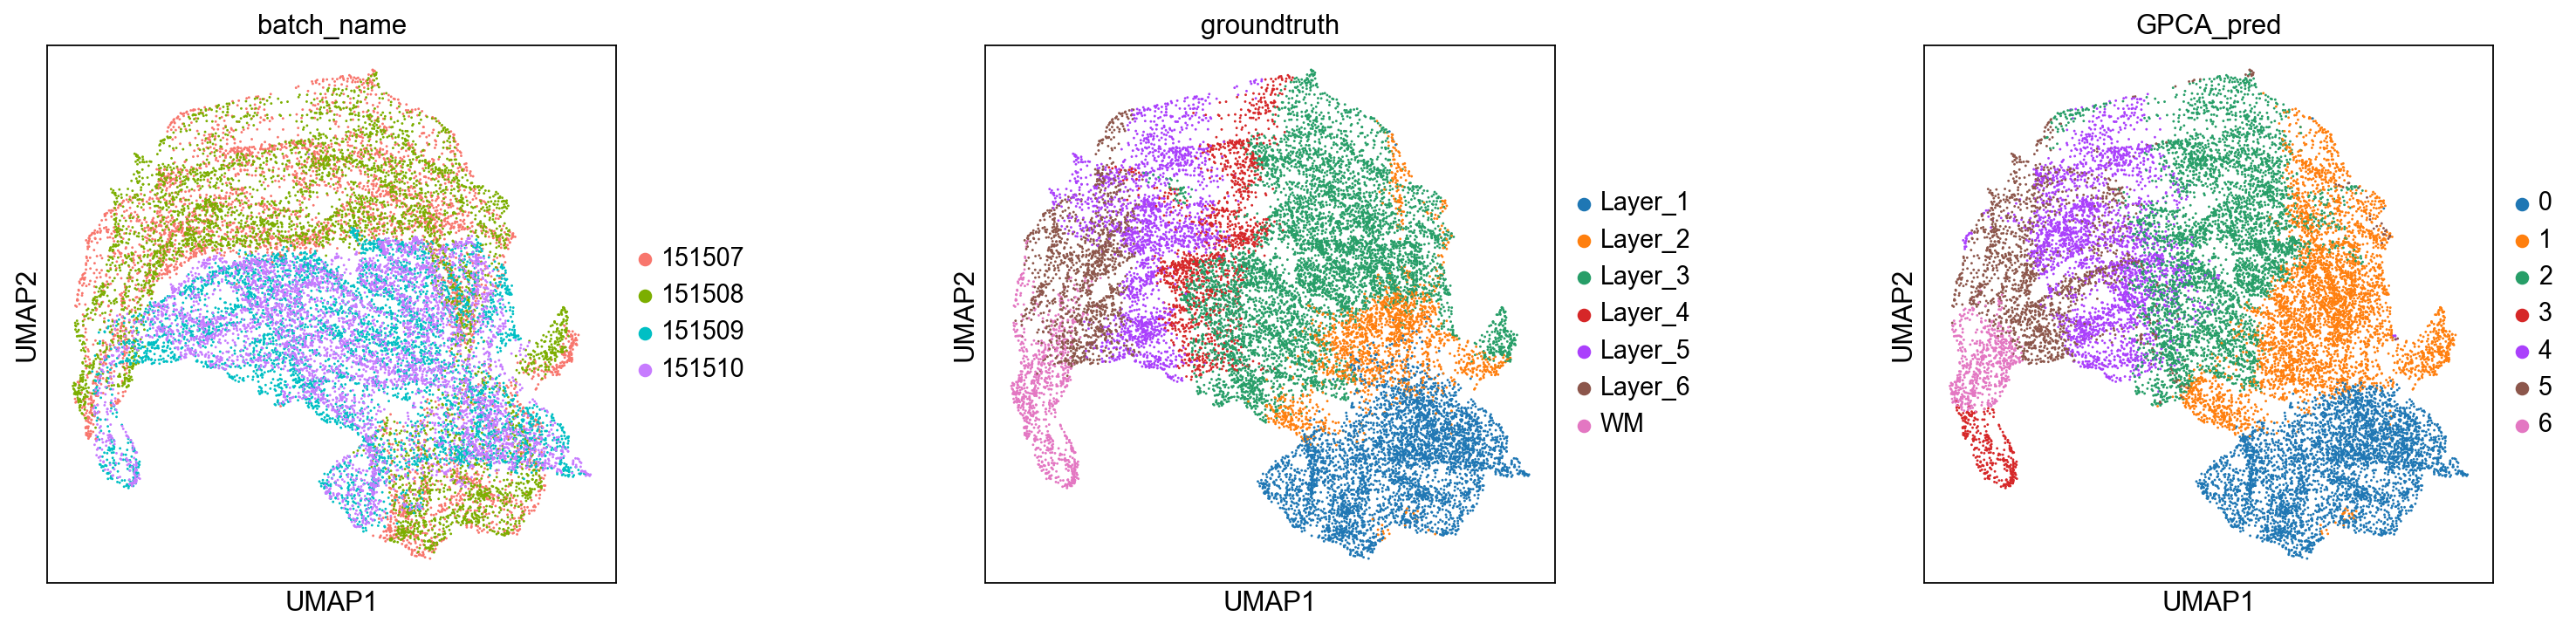

In [396]:
sc.pl.umap(adata_concat, color=['batch_name', 'groundtruth', 'GPCA_pred'], ncols=3, wspace=0.5, show=True)

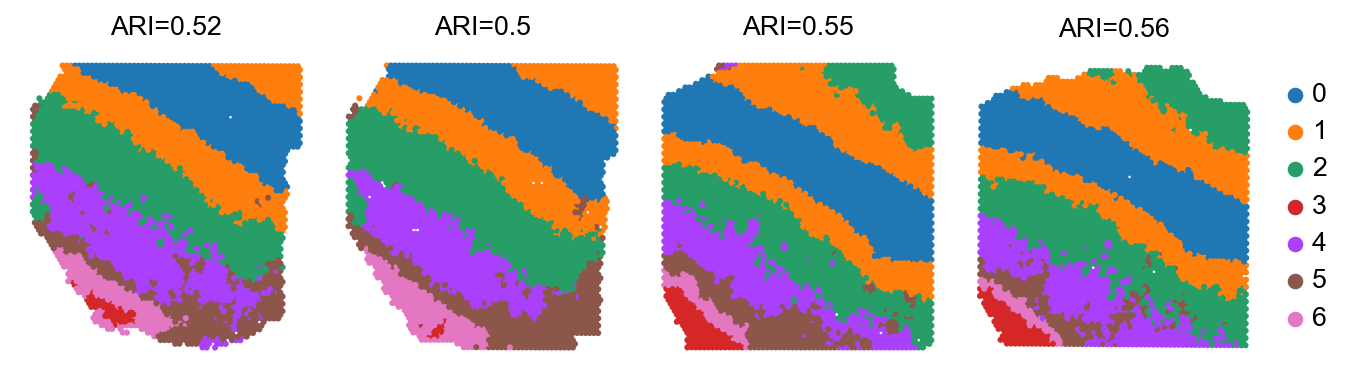

In [397]:
Batch_list = []
for section_id in samples[slice_inds[0]:slice_inds[-1]+1]:
    Batch_list.append(adata_concat[adata_concat.obs['batch_name'] == section_id])

import matplotlib.pyplot as plt
spot_size = 200
title_size = 12
ARI_list = []
for bb in range(4):
    ARI_list.append(round(ari_score(Batch_list[bb].obs['groundtruth'], Batch_list[bb].obs['GPCA_pred']), 2))

fig, ax = plt.subplots(1, 4, figsize=(10, 5), gridspec_kw={'wspace': 0.05, 'hspace': 0.1})
_sc_0 = sc.pl.spatial(Batch_list[0], img_key=None, color=['GPCA_pred'], title=[''],
                      legend_loc=None, legend_fontsize=12, show=False, ax=ax[0], frameon=False,
                      spot_size=spot_size)
_sc_0[0].set_title("ARI=" + str(ARI_list[0]), size=title_size)
_sc_1 = sc.pl.spatial(Batch_list[1], img_key=None, color=['GPCA_pred'], title=[''],
                      legend_loc=None, legend_fontsize=12, show=False, ax=ax[1], frameon=False,
                      spot_size=spot_size)
_sc_1[0].set_title("ARI=" + str(ARI_list[1]), size=title_size)
_sc_2 = sc.pl.spatial(Batch_list[2], img_key=None, color=['GPCA_pred'], title=[''],
                      legend_loc=None, legend_fontsize=12, show=False, ax=ax[2], frameon=False,
                      spot_size=spot_size)
_sc_2[0].set_title("ARI=" + str(ARI_list[2]), size=title_size)
_sc_3 = sc.pl.spatial(Batch_list[3], img_key=None, color=['GPCA_pred'], title=[''],
                      legend_fontsize=12, show=False, ax=ax[3], frameon=False,
                      spot_size=spot_size)
_sc_3[0].set_title("ARI=" + str(ARI_list[3]), size=title_size)
plt.show()

In [398]:
for bb in range(4):
    
    refined_pred=refine(sample_id=Batch_list[bb].obs.index.tolist(), pred=Batch_list[bb].obs["GPCA_pred"].tolist(),
                        dis= pair(Batch_list[bb].obsm["spatial"]), shape="hexagon")
    Batch_list[bb].obs["GPCA_pred"] = refined_pred
    Batch_list[bb].obs["GPCA_pred"] = Batch_list[bb].obs["GPCA_pred"].astype('category')


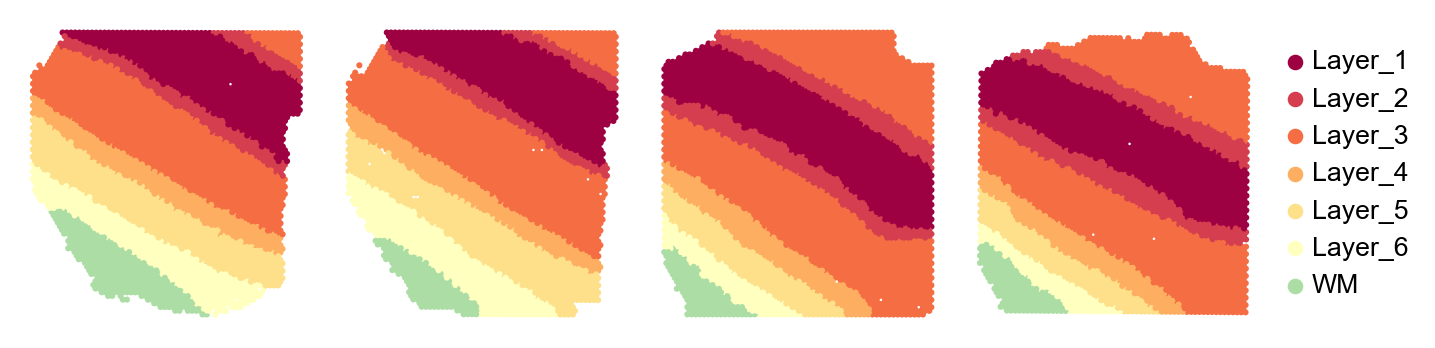

In [481]:
Ref_colors =  np.array(["#9E0142","#D53E4F","#F46D43","#FDAE61","#FEE08B","#FFFFBF","#ABDDA4"])
gt_colors = ["#9E0142","#D53E4F","#F46D43","#FDAE61","#FEE08B","#FFFFBF","#ABDDA4"]
ARI_list = []
for bb in range(4):
    ARI_list.append(round(ari_score(Batch_list[bb].obs['groundtruth'], Batch_list[bb].obs['GPCA_pred']), 2))
    Batch_list[bb].uns['GPCA_pred_colors'] = Ref_colors
    Batch_list[bb].uns['groundtruth_colors'] = gt_colors
fig, ax = plt.subplots(1, 4, figsize=(10, 5), gridspec_kw={'wspace': 0.05, 'hspace': 0.1})

_sc_0 = sc.pl.spatial(Batch_list[0], img_key=None, color=['groundtruth'], title=[''],
                      legend_loc=None, legend_fontsize=12, show=False, ax=ax[0], frameon=False,
                      spot_size=spot_size)
_sc_0[0].set_title("")
_sc_1 = sc.pl.spatial(Batch_list[1], img_key=None, color=['groundtruth'], title=[''],
                      legend_loc=None, legend_fontsize=12, show=False, ax=ax[1], frameon=False,
                      spot_size=spot_size)
_sc_1[0].set_title("")
_sc_2 = sc.pl.spatial(Batch_list[2], img_key=None, color=['groundtruth'], title=[''],
                      legend_loc=None, legend_fontsize=12, show=False, ax=ax[2], frameon=False,
                      spot_size=spot_size)
_sc_2[0].set_title("")
_sc_3 = sc.pl.spatial(Batch_list[3], img_key=None, color=['groundtruth'], title=[''],
                      legend_fontsize=12, show=False, ax=ax[3], frameon=False,
                      spot_size=spot_size)
_sc_3[0].set_title("")
plt.show()

In [414]:
fig.savefig("../../results/DLPFC/figures/Multi-151507-10_groundtruth.pdf")

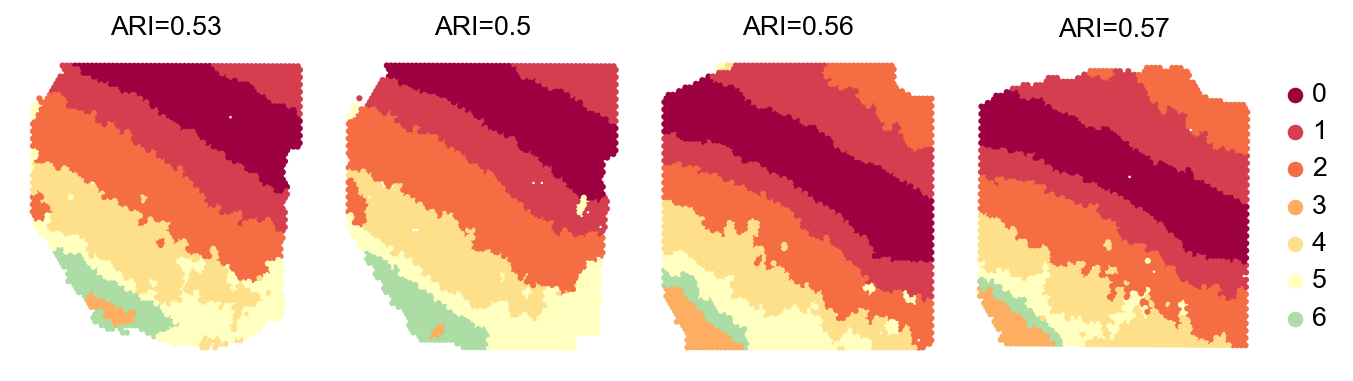

In [415]:
Ref_colors =  np.array(["#9E0142","#D53E4F","#F46D43","#FDAE61","#FEE08B","#FFFFBF","#ABDDA4"])

ARI_list = []
for bb in range(4):
    ARI_list.append(round(ari_score(Batch_list[bb].obs['groundtruth'], Batch_list[bb].obs['GPCA_pred']), 2))
    Batch_list[bb].uns['GPCA_pred_colors'] = Ref_colors
fig, ax = plt.subplots(1, 4, figsize=(10, 5), gridspec_kw={'wspace': 0.05, 'hspace': 0.1})

_sc_0 = sc.pl.spatial(Batch_list[0], img_key=None, color=['GPCA_pred'], title=[''],
                      legend_loc=None, legend_fontsize=12, show=False, ax=ax[0], frameon=False,
                      spot_size=spot_size)
_sc_0[0].set_title("ARI=" + str(ARI_list[0]), size=title_size)
_sc_1 = sc.pl.spatial(Batch_list[1], img_key=None, color=['GPCA_pred'], title=[''],
                      legend_loc=None, legend_fontsize=12, show=False, ax=ax[1], frameon=False,
                      spot_size=spot_size)
_sc_1[0].set_title("ARI=" + str(ARI_list[1]), size=title_size)
_sc_2 = sc.pl.spatial(Batch_list[2], img_key=None, color=['GPCA_pred'], title=[''],
                      legend_loc=None, legend_fontsize=12, show=False, ax=ax[2], frameon=False,
                      spot_size=spot_size)
_sc_2[0].set_title("ARI=" + str(ARI_list[2]), size=title_size)
_sc_3 = sc.pl.spatial(Batch_list[3], img_key=None, color=['GPCA_pred'], title=[''],
                      legend_fontsize=12, show=False, ax=ax[3], frameon=False,
                      spot_size=spot_size)
_sc_3[0].set_title("ARI=" + str(ARI_list[3]), size=title_size)
plt.show()

In [416]:
fig.savefig("../../results/DLPFC/figures/Multi-151507-10_GPCA.pdf")

In [435]:
slice_names = samples[slice_inds[0]:slice_inds[-1]+1]

In [ ]:
# match_list = dict(zip(range(BestK[sample_id]),[5,3,2,0,1,4,6]))
# adata.obs["SpaGCN_pred"] = [match_list[x] for x in adata.obs["SpaGCN_pred"]]
# adata.obs["SpaGCN_pred"] = adata.obs["SpaGCN_pred"].astype('category')

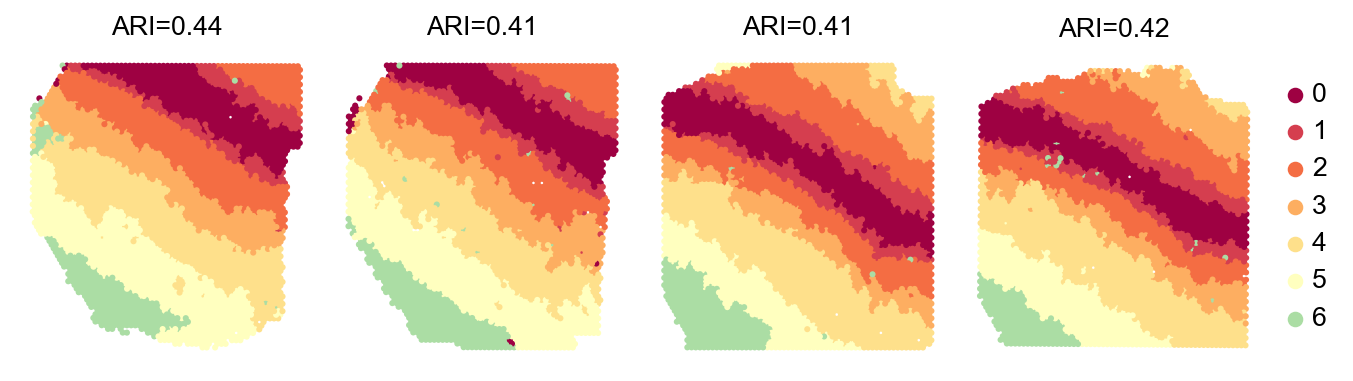

In [474]:
Ref_colors =  np.array(["#9E0142","#D53E4F","#F46D43","#FDAE61","#FEE08B","#FFFFBF","#ABDDA4"])
#Ref_colors =  np.array(["#FDAE61","#FEE08B","#FFFFBF","#9E0142","#F46D43","#ABDDA4","#D53E4F"])
ARI_list = []


for bb in range(4):
    Batch_list[bb].obs["BASS_pred"] = pd.read_csv("../../results/DLPFC/BASS_" + slice_names[bb] + "_pred.csv",index_col=0).BASS_pred
    Batch_list[bb].obs["BASS_pred"] = Batch_list[bb].obs["BASS_pred"].astype("category")
    
    match_list = dict(zip(np.arange(1,8),[3,4,0,5,2,6,1]))
    Batch_list[bb].obs["BASS_pred"] = [match_list[x] for x in Batch_list[bb].obs["BASS_pred"]]
    Batch_list[bb].obs["BASS_pred"] = Batch_list[bb].obs["BASS_pred"].astype('category')
    
    ARI_list.append(round(ari_score(Batch_list[bb].obs['groundtruth'], Batch_list[bb].obs['BASS_pred']), 2))
    Batch_list[bb].uns['BASS_pred_colors'] = Ref_colors

fig, ax = plt.subplots(1, 4, figsize=(10, 5), gridspec_kw={'wspace': 0.05, 'hspace': 0.1})

_sc_0 = sc.pl.spatial(Batch_list[0], img_key=None, color=['BASS_pred'], title=[''],
                      legend_loc=None, legend_fontsize=12, show=False, ax=ax[0], frameon=False,
                      spot_size=spot_size)
_sc_0[0].set_title("ARI=" + str(ARI_list[0]), size=title_size)
_sc_1 = sc.pl.spatial(Batch_list[1], img_key=None, color=['BASS_pred'], title=[''],
                      legend_loc=None, legend_fontsize=12, show=False, ax=ax[1], frameon=False,
                      spot_size=spot_size)
_sc_1[0].set_title("ARI=" + str(ARI_list[1]), size=title_size)
_sc_2 = sc.pl.spatial(Batch_list[2], img_key=None, color=['BASS_pred'], title=[''],
                      legend_loc=None, legend_fontsize=12, show=False, ax=ax[2], frameon=False,
                      spot_size=spot_size)
_sc_2[0].set_title("ARI=" + str(ARI_list[2]), size=title_size)
_sc_3 = sc.pl.spatial(Batch_list[3], img_key=None, color=['BASS_pred'], title=[''],
                      legend_fontsize=12, show=False, ax=ax[3], frameon=False,
                      spot_size=spot_size)
_sc_3[0].set_title("ARI=" + str(ARI_list[3]), size=title_size)
plt.show()



In [475]:
fig.savefig("../../results/DLPFC/figures/Multi-151507-10_BASS.pdf")

In [476]:
STAligner_data = sc.read("../../results/DLPFC/151507-10_STAligner.h5ad")

In [477]:

for i in range(4):
    Batch_list[i].obs["STAligner_pred"] = STAligner_data[STAligner_data.obs['batch_name'] == samples[slice_inds[0]:slice_inds[-1]+1][i]].obs["mclust"]

In [ ]:
Ref_colors =  np.array(["#9E0142","#D53E4F","#F46D43","#FDAE61","#FEE08B","#FFFFBF","#ABDDA4"])

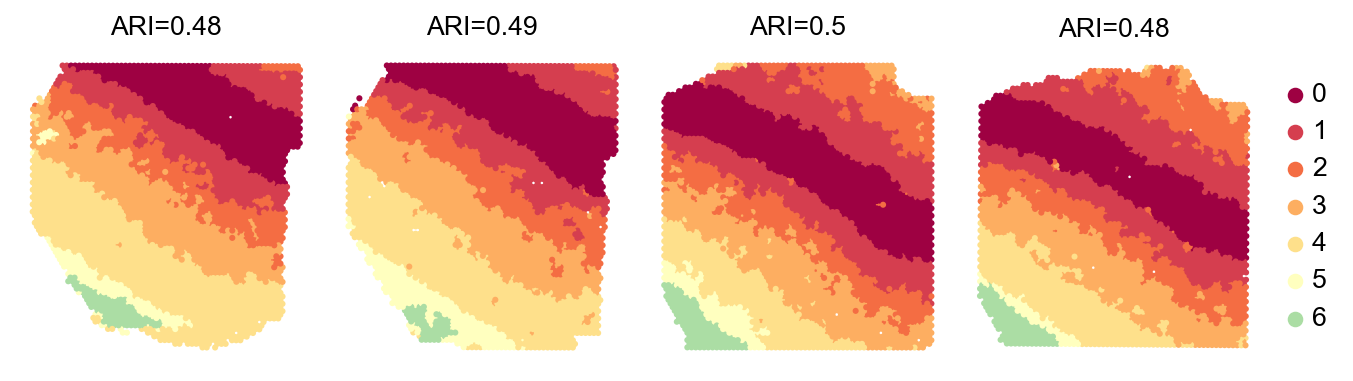

In [479]:
ARI_list = []
for bb in range(4):

    ARI_list.append(round(ari_score(Batch_list[bb].obs['groundtruth'], Batch_list[bb].obs['STAligner_pred']), 2))
    Batch_list[bb].uns['STAligner_pred_colors'] = Ref_colors
fig, ax = plt.subplots(1, 4, figsize=(10, 5), gridspec_kw={'wspace': 0.05, 'hspace': 0.1})

_sc_0 = sc.pl.spatial(Batch_list[0], img_key=None, color=['STAligner_pred'], title=[''],
                      legend_loc=None, legend_fontsize=12, show=False, ax=ax[0], frameon=False,
                      spot_size=spot_size)
_sc_0[0].set_title("ARI=" + str(ARI_list[0]), size=title_size)
_sc_1 = sc.pl.spatial(Batch_list[1], img_key=None, color=['STAligner_pred'], title=[''],
                      legend_loc=None, legend_fontsize=12, show=False, ax=ax[1], frameon=False,
                      spot_size=spot_size)
_sc_1[0].set_title("ARI=" + str(ARI_list[1]), size=title_size)
_sc_2 = sc.pl.spatial(Batch_list[2], img_key=None, color=['STAligner_pred'], title=[''],
                      legend_loc=None, legend_fontsize=12, show=False, ax=ax[2], frameon=False,
                      spot_size=spot_size)
_sc_2[0].set_title("ARI=" + str(ARI_list[2]), size=title_size)
_sc_3 = sc.pl.spatial(Batch_list[3], img_key=None, color=['STAligner_pred'], title=[''],
                      legend_fontsize=12, show=False, ax=ax[3], frameon=False,
                      spot_size=spot_size)
_sc_3[0].set_title("ARI=" + str(ARI_list[3]), size=title_size)
plt.show()



In [480]:
fig.savefig("../../results/DLPFC/figures/Multi-151507-10_STAligner.pdf")

In [483]:
STAligner_data

AnnData object with n_obs × n_vars = 17985 × 1064
    obs: 'in_tissue', 'array_row', 'array_col', 'Ground Truth', 'slice_name', 'batch_name', 'mclust'
    uns: 'Ground Truth_colors', 'batch_name_colors', 'mclust_colors', 'neighbors', 'umap'
    obsm: 'STAGATE', 'STAligner', 'X_umap', 'spatial'
    obsp: 'connectivities', 'distances'

In [484]:
print(ari_score(STAligner_data.obs.mclust,STAligner_data.obs["Ground Truth"]))

0.4837750696163773


In [488]:
adata_concat = ad.concat(Batch_list, label="slice_name", keys=samples[slice_inds[0]:slice_inds[-1]+1])
adata_concat.obs['groundtruth'] = adata_concat.obs['groundtruth'].astype('category')
adata_concat.obs["batch_name"] = adata_concat.obs["slice_name"].astype('category')
print('adata_concat.shape: ', adata_concat.shape)

adata_concat.shape:  (17985, 716)


In [492]:
print(ari_score(adata_concat.obs.STAligner_pred,adata_concat.obs.groundtruth))

0.4837750696163773


In [493]:
print(ari_score(adata_concat.obs.BASS_pred,adata_concat.obs.groundtruth))

0.3895734700643935


In [494]:
print(ari_score(adata_concat.obs.GPCA_pred,adata_concat.obs.groundtruth))

0.5212822864133593


In [495]:
adata_concat.write_h5ad("../../results/DLPFC/Multi_All.h5ad")